# C S 329E HW 11

# Association Analysis - Frequent Itemsets and Rule Generation

## Elena Zhang, Emily Zhou

Association analysis uses machine learning algorithms to extract hidden relationships from large datasets. In this assignment we'll be using one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).

## Bread Basket Data

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - Date: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - Time: Categorical variable that tells us the time of the transactions (HH:MM:SS format). 
  - Transaction: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - Item: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [1]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
df = pd.read_csv("BreadBasket.csv")

In [3]:
# Remove NONE items from the dataframe
df = df[df["Item"] != "NONE"]

1. Plot 20 most frequent items

Text(0.5, 0.98, 'Frequency of Top 20 Most Frequent Items')

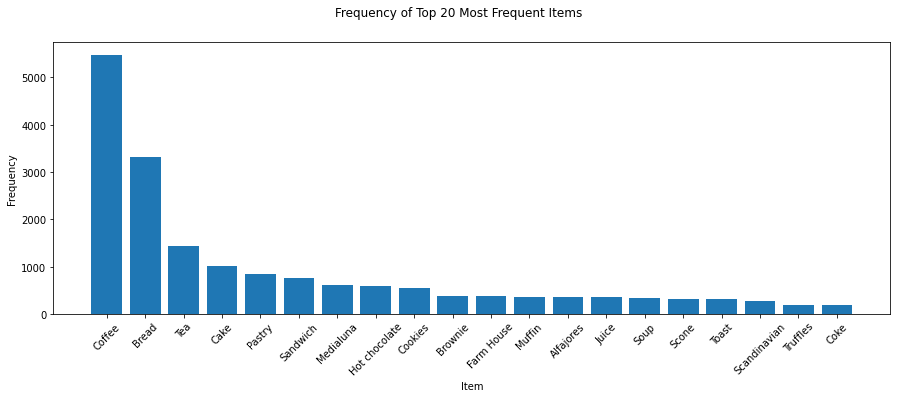

In [4]:
top20 = pd.value_counts(df["Item"])[0:20]

# Plot top 20 items
names = list(top20.keys()) # item names
values = list(top20) # item frequency
fig, axs = plt.subplots(1,1, figsize = (15,5), sharey = True)
axs.bar(names,values) # plot bars
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45) # rotate labels for readability
plt.xlabel("Item") # x axis
plt.ylabel("Frequency") # y axis
fig.suptitle("Frequency of Top 20 Most Frequent Items") # plot title

2. Count number of unique items

In [5]:
df["Item"].nunique()

94

3. Count how many transactions there are in the dataset.

In [6]:
df["Transaction"].nunique()

9465

## Q2 - Data Prep: Convert to One Hot Encoded Transactions
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series. 

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference. 

In [7]:
# List of items in each transaction
transactions = df.groupby("Transaction")["Item"].apply(list).to_list()

In [8]:
transactions[0:4]

[['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin']]

In [9]:
# Encode transaction array into one hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions).astype("int")
te_ary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
# Check one hot encodings using first 4 transactions
te.inverse_transform(te_ary[0:4])

[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin']]

## Q3 - Create Frequent Itemsets 
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices). 

In [11]:
# Set the minsup fraction
minsup_frac = 20/len(transactions)

In [12]:
# make the one hot encoded data into a dataframe
df_encoded = pd.DataFrame(te_ary, columns = te.columns_)

In [13]:
df_encoded.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Find frequent itemset using apriori with minsup = 20
ap = apriori(df_encoded, min_support = minsup_frac, use_colnames = True)

In [15]:
# Show the last 15 frequent item sets
ap.tail(15)

,support,itemsets
229,0.003909,"(Cookies, Coffee, Tea)"
230,0.003064,"(Hot chocolate, Coffee, Medialuna)"
231,0.003803,"(Hot chocolate, Coffee, Pastry)"
232,0.002536,"(Hot chocolate, Coffee, Sandwich)"
233,0.002747,"(Sandwich, Juice, Coffee)"
234,0.004860,"(Medialuna, Coffee, Pastry)"
235,0.003698,"(Coffee, Tea, Medialuna)"
236,0.002853,"(Coffee, Tea, Muffin)"
237,0.004649,"(Coffee, Tea, Pastry)"
238,0.003592,"(Sandwich, Soup, Coffee)"


## Q4 - Generate Strong Rules
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery? 

In [16]:
# Calculate association rules with confidence metric
association_rules(ap, metric = "confidence", min_threshold = 0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648
1,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
2,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
3,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
4,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174
5,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
6,(Frittata),(Coffee),0.008558,0.478394,0.004543,0.530864,1.109680,0.000449,1.111844
7,(Hearty & Seasonal),(Coffee),0.010565,0.478394,0.005705,0.540000,1.128777,0.000651,1.133926
8,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553
9,(Jammie Dodgers),(Coffee),0.013207,0.478394,0.006656,0.504000,1.053525,0.000338,1.051625


➡️ All the rules generated have coffee as the consequent, which suggests that customers are likely to purchase coffee with what they purchased in the antecedent column. The conditional probability of the consequent occurring given the antecedent suggests that transactions with the antecedent and consquent itemsets will occur more than half the time. These rules can be useful if you want to increase sales of coffee. The bakery can run promotions on antecedents which can lead to higher sales of coffee and overall sales count.⬅️


### Q5 - Generate Strong Rules (pt 2)
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [17]:
#calculate rules with lift metric
association_rules(ap, metric = "lift", min_threshold = 3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Sandwich),(Coke),0.071844,0.019440,0.005177,0.072059,3.706722,0.003780,1.056705
1,(Coke),(Sandwich),0.019440,0.071844,0.005177,0.266304,3.706722,0.003780,1.265043
2,(Fudge),(Jam),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
3,(Jam),(Fudge),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
4,(Juice),(Jammie Dodgers),0.038563,0.013207,0.002113,0.054795,4.149041,0.001604,1.043999
5,(Jammie Dodgers),(Juice),0.013207,0.038563,0.002113,0.160000,4.149041,0.001604,1.144568
6,(Spanish Brunch),(Juice),0.018172,0.038563,0.002747,0.151163,3.919879,0.002046,1.132652
7,(Juice),(Spanish Brunch),0.038563,0.018172,0.002747,0.071233,3.919879,0.002046,1.057130
8,(Sandwich),(Mineral water),0.071844,0.014157,0.003275,0.045588,3.220094,0.002258,1.032932
9,(Mineral water),(Sandwich),0.014157,0.071844,0.003275,0.231343,3.220094,0.002258,1.207504


In [18]:
#calculate rules with leverage metric
association_rules(ap, metric = "leverage", min_threshold = .004)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
1,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
2,(Hot chocolate),(Cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125
3,(Cake),(Hot chocolate),0.103856,0.058320,0.011410,0.109868,1.883874,0.005354,1.057910
4,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865
5,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372
6,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
7,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
8,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
9,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682


In [19]:
#calculate rules with conviction metric
association_rules(ap, metric = "conviction", min_threshold = 1.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
1,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
2,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
3,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431
4,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
5,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648
6,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235
7,(Tartine),(Coffee),0.004860,0.478394,0.003064,0.630435,1.317815,0.000739,1.411404
8,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
9,(Vegan mincepie),(Coffee),0.005494,0.478394,0.003170,0.576923,1.205958,0.000541,1.232887


## Q6 - Find the Maximal Itemsets
Using the frequent itemsets and support counts in Q3, find and display all the maximal frequent itemsets along with their support fraction. Also print a count of how many maximal frequent itemsets you have found. (MLxtend does not provide a function to do this - you will need to write it yourself.)

In [20]:
pd.set_option("max_rows", 140)

In [21]:
#find maximal frequent itemsets
maximal = []

for idx, row in ap.iterrows(): 
    ap_copy = ap.copy()
    ap_copy = ap_copy[ap_copy['itemsets'] != row['itemsets']] #filter itemsets to exclude current freq itemset
    #check that current freq itemset is not a subset of any other itemset
    if not any(ap_copy.apply(lambda x: row['itemsets'].issubset(x['itemsets']), axis =1)): 
        maximal.append(row)
        
#display all frequent itemsets
pd.DataFrame(maximal)

,support,itemsets
0,0.004543,(Afternoon with the baker)
12,0.002958,(Eggs)
15,0.005705,(Focaccia)
18,0.002958,(Granola)
42,0.002219,(Tshirt)
45,0.002853,"(Alfajores, Brownie)"
48,0.002430,"(Alfajores, Cookies)"
49,0.003592,"(Hot chocolate, Alfajores)"
50,0.003064,"(Alfajores, Juice)"
51,0.003170,"(Alfajores, Medialuna)"


In [22]:
#count of maximal frequent itemsets
len(maximal)

139

## Q7 - Create Actionable Buisness Insight
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

➡️ Using the maximal freq itemsets, we recommend the bakery to 1) train employees to recommend other frequently purchased items (upselling) and 2) offer a combo menu for a discounted price. 

1) When customers purchase a popular item, like coffee, employees can ask, for example, if they also want to purchase pastries or tea (rule 237) with their order. Since customers naturally purchase these items together, asking them will facilitate making this purchase if they hadn't consciously made up their mind about it.

2) The bakery can offer some maximal frequent itemsets as a single menu item. Offering pre-made combos simplifies decision making for customers and can be offered at cheaper price than purchased separately. The data tells us which combos are popular.⬅️